# Common Test 1. Multi-Class Classification

## Import Libraries

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

# Model
from transformers import ViTConfig, ViTModel

import matplotlib.pyplot as plt

# Set seed for NumPy
np.random.seed(42)

# Set seed for PyTorch
torch.manual_seed(42)


## Data Preprocessing

In [2]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, transforms=None):
        self.folder_path = folder_path
        self.class_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
        
        # Initialize LabelEncoder
        self.label_encoder = LabelEncoder()
        
        # Fit and transform class labels to numerical labels
        self.labels = self.label_encoder.fit_transform(self.class_folders)
        self.transform = transforms
        self.data = []
        
        for class_folder in self.class_folders:
            class_path = os.path.join(folder_path, class_folder)
            file_list = [f for f in os.listdir(class_path) if f.endswith('.npy')]

            for file_name in file_list:
                file_path = os.path.join(class_path, file_name)
                data_point = np.load(file_path)
                self.data.append((data_point, class_folder))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_point, class_name = self.data[idx]
        label = self.label_encoder.transform([class_name])[0]
        
        data_point = (data_point - np.mean(data_point, axis=(1,2)))/(np.std(data_point, axis=(1,2)))
        
        # Convert NumPy array to PyTorch tensor
        data_point = torch.from_numpy(data_point).float()

        if self.transform:
            data_point = self.transform(data_point)

        
        return data_point, label

In [3]:
size = 224

augmentation = transforms.Compose([
    transforms.Resize(size),
])

folder_path = 'dataset/dataset/train/'
custom_dataset = CustomDataset(folder_path, transforms=augmentation)


# Define the size of the training and testing sets[90:10]
train_size = int(0.9 * len(custom_dataset))
test_size = len(custom_dataset) - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

# Define the batch size for your DataLoader
batch_size = 256

# Create DataLoader for training set with shuffling
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for testing set without shuffling
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Validation dataloader
folder_path_val = 'dataset/dataset/val/'
custom_dataset_val = CustomDataset(folder_path, transforms=augmentation)

# You can use shuffle=True to shuffle the data during training
val_dataloader = DataLoader(custom_dataset_val, batch_size=batch_size, shuffle=True)

## Model

Resnet-18 model

In [4]:
class ResNet18(nn.Module):
    def __init__(self, n_classes):
        super(ResNet18, self).__init__()
        
        self.dropout_percentage = 0.5
        self.relu = nn.ReLU()
        
        # BLOCK-1 (starting block) input=(224x224) output=(56x56)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))
        
        # BLOCK-2 (1) input=(56x56) output = (56x56)
        self.conv2_1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_1 = nn.BatchNorm2d(64)
        self.conv2_1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_2 = nn.BatchNorm2d(64)
        self.dropout2_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-2 (2)
        self.conv2_2_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_1 = nn.BatchNorm2d(64)
        self.conv2_2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_2 = nn.BatchNorm2d(64)
        self.dropout2_2 = nn.Dropout(p=self.dropout_percentage)
        
        # BLOCK-3 (1) input=(56x56) output = (28x28)
        self.conv3_1_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm3_1_1 = nn.BatchNorm2d(128)
        self.conv3_1_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_1_2 = nn.BatchNorm2d(128)
        self.concat_adjust_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout3_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-3 (2)
        self.conv3_2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_1 = nn.BatchNorm2d(128)
        self.conv3_2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_2 = nn.BatchNorm2d(128)
        self.dropout3_2 = nn.Dropout(p=self.dropout_percentage)
        
        # BLOCK-4 (1) input=(28x28) output = (14x14)
        self.conv4_1_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm4_1_1 = nn.BatchNorm2d(256)
        self.conv4_1_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_1_2 = nn.BatchNorm2d(256)
        self.concat_adjust_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout4_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-4 (2)
        self.conv4_2_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_1 = nn.BatchNorm2d(256)
        self.conv4_2_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_2 = nn.BatchNorm2d(256)
        self.dropout4_2 = nn.Dropout(p=self.dropout_percentage)
        
        # BLOCK-5 (1) input=(14x14) output = (7x7)
        self.conv5_1_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm5_1_1 = nn.BatchNorm2d(512)
        self.conv5_1_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_1_2 = nn.BatchNorm2d(512)
        self.concat_adjust_5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout5_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-5 (2)
        self.conv5_2_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_1 = nn.BatchNorm2d(512)
        self.conv5_2_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_2 = nn.BatchNorm2d(512)
        self.dropout5_2 = nn.Dropout(p=self.dropout_percentage)
        
        # Final Block input=(7x7) 
        self.avgpool = nn.AvgPool2d(kernel_size=(7,7), stride=(1,1))
        self.fc = nn.Linear(in_features=1*1*512, out_features=1000)
        self.out = nn.Linear(in_features=1000, out_features=n_classes)
        # END
    
    def forward(self, x):
        
        # block 1 --> Starting block
        x = self.relu(self.batchnorm1(self.conv1(x)))
        op1 = self.maxpool1(x)
        
        
        # block2 - 1
        x = self.relu(self.batchnorm2_1_1(self.conv2_1_1(op1)))    # conv2_1 
        x = self.batchnorm2_1_2(self.conv2_1_2(x))                 # conv2_1
        x = self.dropout2_1(x)
        # block2 - Adjust - No adjust in this layer as dimensions are already same
        # block2 - Concatenate 1
        op2_1 = self.relu(x + op1)
        # block2 - 2
        x = self.relu(self.batchnorm2_2_1(self.conv2_2_1(op2_1)))  # conv2_2 
        x = self.batchnorm2_2_2(self.conv2_2_2(x))                 # conv2_2
        x = self.dropout2_2(x)
        # op - block2
        op2 = self.relu(x + op2_1)
    
        
        # block3 - 1[Convolution block]
        x = self.relu(self.batchnorm3_1_1(self.conv3_1_1(op2)))    # conv3_1
        x = self.batchnorm3_1_2(self.conv3_1_2(x))                 # conv3_1
        x = self.dropout3_1(x)
        # block3 - Adjust
        op2 = self.concat_adjust_3(op2) # SKIP CONNECTION
        # block3 - Concatenate 1
        op3_1 = self.relu(x + op2)
        # block3 - 2[Identity Block]
        x = self.relu(self.batchnorm3_2_1(self.conv3_2_1(op3_1)))  # conv3_2
        x = self.batchnorm3_2_2(self.conv3_2_2(x))                 # conv3_2 
        x = self.dropout3_2(x)
        # op - block3
        op3 = self.relu(x + op3_1)
        
        
        # block4 - 1[Convolition block]
        x = self.relu(self.batchnorm4_1_1(self.conv4_1_1(op3)))    # conv4_1
        x = self.batchnorm4_1_2(self.conv4_1_2(x))                 # conv4_1
        x = self.dropout4_1(x)
        # block4 - Adjust
        op3 = self.concat_adjust_4(op3) # SKIP CONNECTION
        # block4 - Concatenate 1
        op4_1 = self.relu(x + op3)
        # block4 - 2[Identity Block]
        x = self.relu(self.batchnorm4_2_1(self.conv4_2_1(op4_1)))  # conv4_2
        x = self.batchnorm4_2_2(self.conv4_2_2(x))                 # conv4_2
        x = self.dropout4_2(x)
        # op - block4
        op4 = self.relu(x + op4_1)

        
        # block5 - 1[Convolution Block]
        x = self.relu(self.batchnorm5_1_1(self.conv5_1_1(op4)))    # conv5_1
        x = self.batchnorm5_1_2(self.conv5_1_2(x))                 # conv5_1
        x = self.dropout5_1(x)
        # block5 - Adjust
        op4 = self.concat_adjust_5(op4) # SKIP CONNECTION
        # block5 - Concatenate 1
        op5_1 = self.relu(x + op4)
        # block5 - 2[Identity Block]
        x = self.relu(self.batchnorm5_2_1(self.conv5_2_1(op5_1)))  # conv5_2
        x = self.batchnorm5_2_1(self.conv5_2_1(x))                 # conv5_2
        x = self.dropout5_2(x)
        # op - block5
        op5 = self.relu(x + op5_1)


        # FINAL BLOCK - classifier 
        x = self.avgpool(op5)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc(x))
        x = self.out(x)
        x = F.softmax(x, dim=1)

        return x

## Training

In [6]:
## Model 
model = ResNet18(n_classes = 3)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 500
best_accuracy = 0.0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)

    # Validation phase
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for test_inputs, test_labels in test_dataloader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
            test_outputs = model(test_inputs)
            _, predicted = torch.max(test_outputs, 1)
            total_samples += test_labels.size(0)
            total_correct += (predicted == test_labels).sum().item()

    # Calculate accuracy
    accuracy = total_correct / total_samples

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'Save_weights/Resnet-18.pth')
        
    # Print training and validation statistics
    print(f"Epoch {epoch + 1}/{num_epochs}, Test Loss: {avg_loss}, Accuracy on Test set: {accuracy * 100:.2f}%")



Epoch 1/500, Test Loss: 1.1042119714449037, Accuracy on Test set: 35.30%
Epoch 2/500, Test Loss: 1.0991293619263847, Accuracy on Test set: 35.23%
Epoch 3/500, Test Loss: 1.0985938445577081, Accuracy on Test set: 35.30%
Epoch 4/500, Test Loss: 1.0983712392033271, Accuracy on Test set: 35.30%
Epoch 5/500, Test Loss: 1.0984850368409786, Accuracy on Test set: 35.30%
Epoch 6/500, Test Loss: 1.0983055537601687, Accuracy on Test set: 35.30%
Epoch 7/500, Test Loss: 1.098492387330757, Accuracy on Test set: 34.47%
Epoch 8/500, Test Loss: 1.0981513767872217, Accuracy on Test set: 35.30%
Epoch 9/500, Test Loss: 1.0980716561371426, Accuracy on Test set: 34.53%
Epoch 10/500, Test Loss: 1.0982946123716966, Accuracy on Test set: 35.23%
Epoch 11/500, Test Loss: 1.0980825086809554, Accuracy on Test set: 35.30%
Epoch 12/500, Test Loss: 1.0980616054444943, Accuracy on Test set: 32.90%
Epoch 13/500, Test Loss: 1.0986338201558814, Accuracy on Test set: 35.23%
Epoch 14/500, Test Loss: 1.0985806022050246, Acc

The model is saved when it reaches its peak test accuracy(90.57) at the 300th epoch, marking this epoch as the point where the best test performance is recorded.

## Evaluation Metrics: ROC curve and AUC score for Best Model

In [8]:
checkpoint = "Save_weights/Resnet-18.pth"
model = ResNet18(n_classes=3).to(device)
model.load_state_dict(torch.load(checkpoint))

<All keys matched successfully>

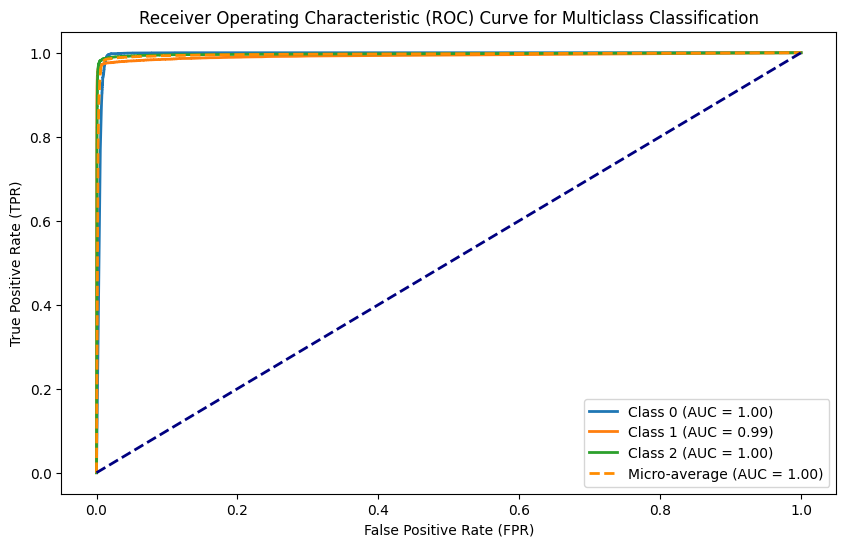

In [9]:
model.eval()
num_classes = 3
all_labels = []
all_scores = []

with torch.no_grad():
    for val_inputs, val_labels in val_dataloader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        
        # Assuming the model outputs raw logits, apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
        
        all_labels.extend(val_labels.cpu().numpy())
        all_scores.extend(probabilities.cpu().numpy())

# Binarize the labels
y_true = label_binarize(all_labels, classes=list(range(num_classes)))

# Ensure y_true and all_scores are numpy arrays
y_true = np.array(y_true)
all_scores = np.array(all_scores)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), all_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='darkorange', linestyle='--', lw=2, label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

## Discussion

The provided scenario presents a comprehensive setup for a classification task involving three classes (no, sphere, vort). 

Model chosen : Resnet18  
ResNet18 architecture signifies a robust choice for image classification tasks, especially when dealing with relatively small datasets like the one described.
ResNet architectures are renowned for their ability to effectively train deep neural networks, thanks to skip connections that facilitate the flow of gradients during training, thus mitigating the vanishing gradient problem.

The model has been trained using the Adam optimizer with a learning rate of 1e-4, utilizing binary cross-entropy loss over the course of 500 epochs, with the best-performing model identified at the 300th epoch. 